In [ ]:
!pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import rarfile
import os

# Chemin d'accès au fichier .rar
rar_file_path = "/content/drive/MyDrive/train-90.rar"

# Ouvrir le fichier .rar
with rarfile.RarFile(rar_file_path) as rar:
    # Extraire tous les fichiers du .rar
    rar.extractall()




In [ ]:
import rarfile
import os

# Chemin d'accès au fichier .rar
rar_file_path = "/content/drive/MyDrive/test-90.rar"

# Ouvrir le fichier .rar
with rarfile.RarFile(rar_file_path) as rar:
    # Extraire tous les fichiers du .rar
    rar.extractall()

In [ ]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


In [ ]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9630 sha256=c76c63286597c4dc52e42353742cb72fc409379a4a88d709c894a5df768ce282
  Stored in directory: /root/.cache/pip/wheels/4c/9b/0a/a78ff56725af3ef70792f9ed0f8dbbc4c0315edc62cbc4a6b8
Successfully built progress


In [ ]:
import os
import random
import itertools
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
from progress.bar import Bar
import heapq
from scipy.stats.stats import pearsonr

def dataGeneration(data_path, csv_path, record_path):

    # initialize dataset
    dataset = pd.DataFrame(columns=['label', 'record'])

    if record_path == None:

        # a loop for each patient
        detail_path = data_path + '/'
        record_files = [i.split('.')[0] for i in os.listdir(detail_path) if (not i.startswith('.') and i.endswith('.hea'))]

        Bar.check_tty = False
        bar = Bar('Processing', max=len(record_files), fill='#', suffix='%(percent)d%%')

        # a loop for each record
        for record_name in record_files:

            # load record
            signal, info = wfdb.rdsamp(detail_path + record_name)

            fs = 200

            signal = processing.resample_sig(signal[:,0], info['fs'], fs)[0]

            # set some parameters
            window_size_half = int(fs * 0.125 / 2)
            max_bpm = 230

            # detect QRS peaks
            qrs_inds = processing.gqrs_detect(signal, fs=fs)
            search_radius = int(fs*60/max_bpm)
            corrected_qrs_inds = processing.correct_peaks(signal, peak_inds=qrs_inds, search_radius=search_radius, smooth_window_size=150)

            average_qrs = 0
            count = 0
            for i in range(1, len(corrected_qrs_inds)-1):
                start_ind = corrected_qrs_inds[i] - window_size_half
                end_ind = corrected_qrs_inds[i] + window_size_half + 1
                if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                    continue
                average_qrs = average_qrs + signal[start_ind: end_ind]
                count = count + 1

            # remove outliers
            if count < 8:
                print('\noutlier detected, discard ' + record_name)
                continue

            average_qrs = average_qrs / count

            corrcoefs = []
            for i in range(1, len(corrected_qrs_inds)-1):
                start_ind = corrected_qrs_inds[i] - window_size_half
                end_ind = corrected_qrs_inds[i] + window_size_half + 1
                if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                    corrcoefs.append(-100)
                    continue
                corrcoef = pearsonr(signal[start_ind: end_ind], average_qrs)[0]
                corrcoefs.append(corrcoef)

            max_corr = list(map(corrcoefs.index, heapq.nlargest(8, corrcoefs)))

            index_corr = random.sample(list(itertools.permutations(max_corr, 8)), 100)

            for index in index_corr:
                # a temp dataframe to store one record
                record_temp = pd.DataFrame()

                signal_temp = []

                for i in index:
                    start_ind = corrected_qrs_inds[i + 1] - window_size_half
                    end_ind = corrected_qrs_inds[i + 1] + window_size_half + 1
                    sig = processing.normalize_bound(signal[start_ind: end_ind], -1, 1)
                    signal_temp = np.concatenate((signal_temp, sig))

                record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
                record_temp['label'] = record_name
                record_temp['record'] = record_name

                # add it to final dataset
                dataset = dataset.append(record_temp, ignore_index=True, sort=False)
                
            bar.next()    
        bar.finish()    
    else:
        patient_folders = [i for i in os.listdir(data_path) if (not i.startswith('.') and i.startswith(record_path))]

        Bar.check_tty = False
        bar = Bar('Processing', max=len(patient_folders), fill='#', suffix='%(percent)d%%')
        # a loop for each patient
        for patient_name in patient_folders:
            detail_path = data_path + patient_name + '/'
            record_files = [i.split('.')[0] for i in os.listdir(detail_path) if i.endswith('.hea')]

            # a loop for each record
            for record_name in record_files:

                # load record
                signal, info = wfdb.rdsamp(detail_path + record_name)

                fs = 200

                signal = processing.resample_sig(signal[:,0], info['fs'], fs)[0]

                # set some parameters
                window_size_half = int(fs * 0.125 / 2)
                max_bpm = 230

                # detect QRS peaks
                qrs_inds = processing.gqrs_detect(signal, fs=fs)
                search_radius = int(fs*60/max_bpm)
                corrected_qrs_inds = processing.correct_peaks(signal, peak_inds=qrs_inds, search_radius=search_radius, smooth_window_size=150)

                average_qrs = 0
                count = 0
                for i in range(1, len(corrected_qrs_inds)-1):
                    start_ind = corrected_qrs_inds[i] - window_size_half
                    end_ind = corrected_qrs_inds[i] + window_size_half + 1
                    if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                        continue
                    average_qrs = average_qrs + signal[start_ind: end_ind]
                    count = count + 1

                # remove outliers
                if count < 8:
                    print('\noutlier detected, discard ' + record_name + ' of ' + patient_name)
                    continue

                average_qrs = average_qrs / count

                corrcoefs = []
                for i in range(1, len(corrected_qrs_inds)-1):
                    start_ind = corrected_qrs_inds[i] - window_size_half
                    end_ind = corrected_qrs_inds[i] + window_size_half + 1
                    if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                        corrcoefs.append(-100)
                        continue
                    corrcoef = pearsonr(signal[start_ind: end_ind], average_qrs)[0]
                    corrcoefs.append(corrcoef)

                max_corr = list(map(corrcoefs.index, heapq.nlargest(8, corrcoefs)))

                index_corr = random.sample(list(itertools.permutations(max_corr, 8)), 100)

                for index in index_corr:
                    # a temp dataframe to store one record
                    record_temp = pd.DataFrame()

                    signal_temp = []

                    for i in index:
                        start_ind = corrected_qrs_inds[i + 1] - window_size_half
                        end_ind = corrected_qrs_inds[i + 1] + window_size_half + 1
                        sig = processing.normalize_bound(signal[start_ind: end_ind], -1, 1)
                        signal_temp = np.concatenate((signal_temp, sig))

                    record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
                    record_temp['label'] = patient_name
                    record_temp['record'] = record_name

                    # add it to final dataset
                    dataset = dataset.append(record_temp, ignore_index=True, sort=False)
                
            bar.next()    
        bar.finish()

    # save for further use
    dataset.to_csv(csv_path, index=False)

    print('processing completed')

<ipython-input-4-c02640dd9104>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
   dataset_name = '/content/test-90/'
   record_path = 'Person'
    # root path
   data_path =  dataset_name 

   csv_path =  'test90.csv'

   dataGeneration(data_path, csv_path, record_path)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  dataset = dataset.append(record_temp, ignore_index=True, sort=False)
<ipython-input-21-c02640dd9104>:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
<ipython-input-21-c02640dd9104>:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(record_temp, ignore_index=True, sort=False)
<ipython-input-21-c02640dd9104>:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
<ipython-input-21-

processing completed


In [ ]:
   dataset_name = '/content/train-90/'
   record_path = 'Person'
    # root path
   data_path =  dataset_name 

   csv_path =  'train90.csv'

   dataGeneration(data_path, csv_path, record_path)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  dataset = dataset.append(record_temp, ignore_index=True, sort=False)
<ipython-input-21-c02640dd9104>:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
<ipython-input-21-c02640dd9104>:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(record_temp, ignore_index=True, sort=False)
<ipython-input-21-c02640dd9104>:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
<ipython-input-21-

processing completed


In [ ]:
tf=pd.read_csv('./train90.csv')

In [ ]:
tf

,label,record,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
0,Person_41,rec_1,-0.781256,-0.666767,-0.540750,-0.778218,-0.541251,-0.805990,-0.892412,-1.000000,...,0.079692,-0.535416,-0.626852,-0.647073,-0.607983,-0.702607,-0.599674,-0.779113,-0.574648,-0.729540
1,Person_41,rec_1,-0.689748,-0.672627,-0.709100,-0.814407,-0.678150,-0.750641,-0.763887,-0.887239,...,-0.112137,-0.537296,-0.583134,-0.659375,-0.766725,-0.601004,-0.590279,-0.737301,-0.577102,-0.659297
2,Person_41,rec_1,-0.557068,-0.797804,-0.628549,-0.678397,-0.620014,-0.766657,-0.760782,-0.956869,...,0.138058,-0.394491,-0.562362,-0.723017,-0.648746,-0.561346,-0.641516,-0.702258,-0.537578,-0.665756
3,Person_41,rec_1,-0.718358,-0.680127,-0.669193,-0.595935,-0.657538,-0.767103,-0.996476,-1.000000,...,-0.035100,-0.376768,-0.633534,-0.684166,-0.808965,-0.648555,-0.837995,-0.568333,-0.611913,-0.682212
4,Person_41,rec_1,-0.566238,-0.691320,-0.595638,-0.627863,-0.516095,-0.608061,-0.805397,-1.000000,...,-0.048976,-0.633485,-0.623240,-0.462260,-0.601322,-0.620581,-0.626485,-0.706980,-0.532074,-0.737515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20795,Person_68,rec_1,-0.718349,-0.866007,-0.700512,-0.604024,-0.848409,-0.748228,-0.774677,-0.647936,...,-0.475784,-0.389398,-1.000000,-0.722749,-0.814677,-0.583061,-0.519584,-0.549736,-0.710985,-0.787949
20796,Person_68,rec_1,-0.561082,-0.505842,-0.569313,-0.690696,-0.544733,-0.648602,-0.697983,-0.548069,...,-0.475784,-0.389398,-1.000000,-0.722749,-0.814677,-0.583061,-0.519584,-0.549736,-0.710985,-0.787949
20797,Person_68,rec_1,-0.576663,-0.767718,-0.680347,-0.630877,-0.620291,-0.668191,-0.741775,-0.612621,...,-0.372037,-0.293948,-1.000000,-0.826472,-0.727801,-0.575496,-0.507729,-0.635142,-0.642233,-0.614065
20798,Person_68,rec_1,-0.824758,-0.869420,-0.873729,-0.924325,-0.821490,-0.808804,-0.822721,-0.771076,...,-0.660939,-0.241690,-0.762375,-1.000000,-0.824730,-0.637966,-0.581877,-0.682725,-0.674330,-0.731381


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
import keras.backend as K
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Softmax, Conv1D, Dense, Dropout, ReLU, MaxPooling1D, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [ ]:
# Split data into training and test partitions
def createSet(dataset):
    x_cols = [col for col in dataset.columns if (col != 'label' and col != 'record')]
    X_data = dataset[x_cols].values
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], -1))
    Y_data = dataset['label'].values

    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state=0, test_size = 0.3, train_size = 0.7)

    num_classes = len(np.unique(Y_data))

    return num_classes,X_train, X_test, Y_train, Y_test 

In [ ]:
# Convert class vectors to binary class matrices
def binaryConvertion(num_classes, Y_train, Y_test):

    Y_train_encoder = sklearn.preprocessing.LabelEncoder()
    Y_train_num = Y_train_encoder.fit_transform(Y_train)
    Y_train_wide = np_utils.to_categorical(Y_train_num, num_classes)

    Y_test_num = Y_train_encoder.fit_transform(Y_test)
    Y_test_wide = np_utils.to_categorical(Y_test_num, num_classes)

    return Y_train_wide, Y_test_num, Y_test_wide

In [ ]:
def modelling(X_train,Y_train_wide):
    input_shape = (X_train.shape[1], X_train.shape[2])
    inputs = Input(shape=input_shape)
    x = Conv1D(16, 7)(inputs)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=2)(x)

    x = Conv1D(32 ,5)(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=2)(x)

    x = Conv1D(64, 5)(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=2)(x)

    x = Conv1D(128, 7)(x)
    x = ReLU()(x)

    x = Conv1D(128, 7)(x)
    x = ReLU()(x)

    x = Conv1D(128, 8)(x)
    x = ReLU()(x)
    x = Flatten()(x)
    x = Dense(num_classes)(x)

    predictions = Softmax()(x)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()


    batch_size = 32
    epochs = 10

    best_weights_filepath = './best_weights.hdf5'
    mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                        save_best_only=True, save_weights_only=False)

    history = model.fit(X_train,Y_train_wide,
            batch_size=batch_size,
            epochs=epochs,
            verbose = 1,
            validation_split = 0.2,
            shuffle=True,
            callbacks=[mcp])

    model.load_weights(best_weights_filepath)

    model.save('model.h5')

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.xticks(range(0,epochs)[0::2])
    plt.legend()
    plt.show()

    return model

In [ ]:
def evaluation(model, X_test, Y_test_num):

    # make a set of predictions for the test data
    pred = np.argmax(model.predict(X_test), axis=-1)

    # print performance details
    print(metrics.classification_report(Y_test_num, pred))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 194, 16)           128       
                                                                 
 re_lu (ReLU)                (None, 194, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            2592      
                                                                 
 re_lu_1 (ReLU)              (None, 92, 32)            0         
                                                             

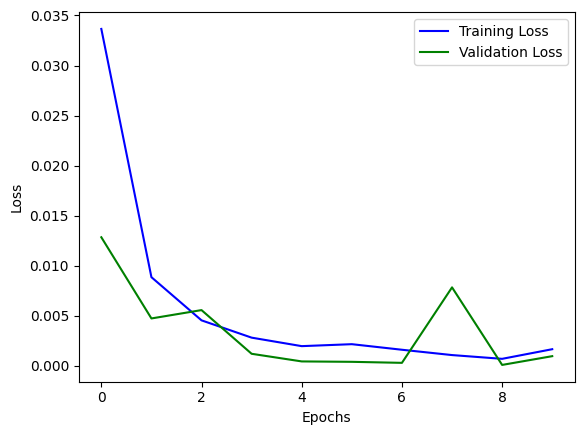

195/195 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       501
           1       1.00      1.00      1.00       495
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        26
           6       1.00      1.00      1.00        29
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00       146
           9       1.00      1.00      1.00       109
          10       1.00      1.00      1.00        65
          11       1.00      1.00      1.00        35
          12       1.00      1.00      1.00        39
          13       1.00      1.00      1.00        56
          14       1.00      1.00      1.00        27
          15       1.00      1.00      1.00        58
          16       0.96   

In [ ]:
    dataset1 = pd.read_csv("/content/train90.csv")
   

    num_classes,X_train, X_test, Y_train, Y_test = createSet(dataset1)
    
    Y_train_wide, Y_test_num, Y_test_wide = binaryConvertion(num_classes, Y_train, Y_test)
    model = modelling(X_train, Y_train_wide)
    evaluation(model, X_test, Y_test_num)

In [ ]:
testing=pd.read_csv("./test90 (1).csv")

In [ ]:
testing.shape

(11000, 202)

In [ ]:
t=testing['label'].value_counts()

In [ ]:
t

Person_02    500
Person_71    500
Person_01    400
Person_70    300
Person_52    300
            ... 
Person_79    100
Person_89    100
Person_58    100
Person_78    100
Person_68    100
Name: label, Length: 90, dtype: int64

In [ ]:
t.describe()

count     90.000000
mean     122.222222
std       74.619300
min      100.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      500.000000
Name: label, dtype: float64

In [ ]:
x=testing.iloc[100:125]

In [ ]:
x

,label,record,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
100,Person_18,rec_2,-0.742618,-0.604674,-0.748328,-0.987423,-0.798357,-0.585185,-0.789334,-0.830920,...,0.662653,-0.192369,-0.911500,-0.867693,-0.411447,-0.566306,-0.984473,-0.732183,-0.422090,-0.553958
101,Person_18,rec_2,-0.748636,-0.734687,-0.781261,-1.000000,-0.638726,-0.463656,-0.847655,-0.860924,...,0.015619,-0.597865,-0.588810,-0.864069,-0.777664,-0.567037,-0.326302,-0.765890,-0.816458,-0.585950
102,Person_18,rec_2,-0.463894,-0.675546,-0.770189,-0.375172,-0.367245,-0.748465,-0.647135,-0.432679,...,-0.330765,-0.709292,-0.748744,-0.888032,-0.910101,-0.757051,-0.598720,-1.000000,-0.800566,-0.757709
103,Person_18,rec_2,-0.607982,-0.998339,-0.905041,-0.433547,-0.342093,-0.773841,-0.732482,-0.386480,...,0.446026,-0.189070,-1.000000,-0.789174,-0.518970,-0.381674,-0.667354,-0.638356,-0.424910,-0.471514
104,Person_18,rec_2,-0.607982,-0.998339,-0.905041,-0.433547,-0.342093,-0.773841,-0.732482,-0.386480,...,0.040005,-0.609888,-1.000000,-0.943733,-0.660418,-0.716823,-0.657275,-0.924217,-0.589487,-0.339014
105,Person_18,rec_2,-0.748636,-0.734687,-0.781261,-1.000000,-0.638726,-0.463656,-0.847655,-0.860924,...,0.446026,-0.189070,-1.000000,-0.789174,-0.518970,-0.381674,-0.667354,-0.638356,-0.424910,-0.471514
106,Person_18,rec_2,-0.742618,-0.604674,-0.748328,-0.987423,-0.798357,-0.585185,-0.789334,-0.830920,...,0.040005,-0.609888,-1.000000,-0.943733,-0.660418,-0.716823,-0.657275,-0.924217,-0.589487,-0.339014
107,Person_18,rec_2,-0.493283,-0.724401,-0.777784,-0.654640,-0.501605,-0.940758,-0.836157,-0.517432,...,0.662653,-0.192369,-0.911500,-0.867693,-0.411447,-0.566306,-0.984473,-0.732183,-0.422090,-0.553958
108,Person_18,rec_2,-0.622325,-0.734271,-0.728815,-0.753637,-0.582142,-0.731048,-0.997811,-0.613282,...,-0.202092,-0.564488,-0.729138,-0.714490,-0.436813,-0.513977,-0.866617,-1.000000,-0.535584,-0.509994
109,Person_18,rec_2,-0.742618,-0.604674,-0.748328,-0.987423,-0.798357,-0.585185,-0.789334,-0.830920,...,0.181577,-0.539100,-0.984505,-1.000000,-0.516283,-0.360594,-0.829109,-0.860089,-0.494575,-0.462840


In [ ]:
fert=x.label.values
fert

array(['Person_18', 'Person_18', 'Person_18', 'Person_18', 'Person_18',
       'Person_18', 'Person_18', 'Person_18', 'Person_18', 'Person_18',
       'Person_18', 'Person_18', 'Person_18', 'Person_18', 'Person_18',
       'Person_18', 'Person_18', 'Person_18', 'Person_18', 'Person_18',
       'Person_18', 'Person_18', 'Person_18', 'Person_18', 'Person_18'],
      dtype=object)

In [ ]:
np.unique(fert)

array(['Person_18'], dtype=object)

In [ ]:
fert =x.label.values 

x_cols =[col for col in x.columns if(col != 'label' and col != 'record')]
x_data =x[x_cols].values
x_data = np.reshape(x_data,(x_data.shape[0],x_data.shape[1],-1))
Y_data = x['label'].values
print(Y_data)
print(Y_data.shape)
print(np.unique(Y_data))
Y_train_encoder = sklearn.preprocessing.LabelEncoder()

Y_test_num = Y_train_encoder.fit_transform(Y_data)
print(num_classes)
#Y_test_wide = np_utils.to_categorical(Y_test_num, num_classes)



#print(Y_test_num)
#print(Y_test_num.shape)
#print(np.unique(Y_test_num))

my_list = Y_test_num.tolist()
most_common = max(set(my_list), key = my_list.count)
print(most_common)



pred = np.argmax(model.predict(x_data),axis=-1)+1
print(pred)
print(metrics.classification_report(Y_test_num, pred))

['Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18'
 'Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18'
 'Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18'
 'Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18' 'Person_18'
 'Person_18']
(25,)
['Person_18']
90
0
1/1 [==============================] - 0s 279ms/step
[18 18 18 18 16 18 88 18 18 16 18 18 18 16 18 16  1 18 18 18 18 18 18 18
 18]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      25.0
           1       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       0.0
          18       0.00      0.00      0.00       0.0
          88       0.00      0.00      0.00       0.0

    accuracy                           0.00      25.0
   macro avg       0.00      0.00      0.00      25.0
weighted avg       0.00      0.00      0.00      25.0



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
#evaluation(model, x_data, Y_test_num)

In [ ]:
np.unique(pred)

array([ 1, 16, 18, 88])

In [ ]:
my_list = pred.tolist()

In [ ]:
most_common = max(set(my_list), key = my_list.count)
print(most_common)


18


In [ ]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9630 sha256=f0ea143a36a925b0a74752d5d1267ea43f108fa89ebe45d36dacbab7062fdbaa
  Stored in directory: /root/.cache/pip/wheels/4c/9b/0a/a78ff56725af3ef70792f9ed0f8dbbc4c0315edc62cbc4a6b8
Successfully built progress


In [ ]:
import numpy as np
import pandas as pd
from progress.bar import Bar
import matplotlib.pyplot as plt
from matplotlib import ticker

import keras
import keras.backend as K

In [ ]:
def weightTransform(W, mode = 1, n = 1):

    if mode == 1:
        W_new = W
    elif mode == 2:
        W_new = np.sign(W)
    else:
        W_new = np.round(W * (np.power(2, n)))
    return W_new

In [ ]:
def rebuildModel(model_path):

    model = keras.models.load_model(model_path)
    count = 0
    layer_outputs = []
    for layer in model.layers:
        if layer.name.startswith('dropout'):
            break

        if layer.name.startswith('conv1d'):
            weights = layer.get_weights()
            for i in range(len(weights)):
                w = weightTransform(weights[i])
                count = count + np.size(w)
                weights[i] = weightTransform(weights[i])
            layer.set_weights(weights)

        output = layer.output
        layer_outputs.append(output)
    print("Original Weight\nMultiplication Number: ", count)
    model_template = keras.Model(inputs=model.input, outputs=layer_outputs)

    return model_template

In [ ]:

def rebuildModelBNN(model_path):

    model = keras.models.load_model(model_path)
    count_inv = 0
    layer_outputs = []
    for layer in model.layers:
        if layer.name.startswith('dropout'):
            break

        if layer.name.startswith('conv1d'):
            weights = layer.get_weights()
            for i in range(len(weights)):
                w = weightTransform(weights[i], 2)
                count_inv = count_inv + np.sum(w < 0)
                weights[i] = weightTransform(weights[i], 2)
            layer.set_weights(weights)

        output = layer.output
        layer_outputs.append(output)
    print("Binary Weight\nInversion Number: ", count_inv)
    model_template = keras.Model(inputs=model.input, outputs=layer_outputs)

    return model_template

In [ ]:
def rebuildModelENN(model_path, n):

    model = keras.models.load_model(model_path)
    count = 0
    count_inv = 0
    count_shift = 0
    layer_outputs = []

    for layer in model.layers:
        if layer.name.startswith('dropout'):
            break

        if layer.name.startswith('conv1d'):
            weights = layer.get_weights()
            for i in range(len(weights)):
                w = weightTransform(weights[i], 3, n)
                if i==0:
                    count = count + np.size(w)
                    count_shift = count_shift + np.size(w)
                    count_inv = count_inv + np.sum(w < 0)
                if i==1:
                    count = count + np.size(w)

                weights[i] = weightTransform(weights[i], 3, n) / (np.power(2, n))
            layer.set_weights(weights)

        output = layer.output
        layer_outputs.append(output)
    print("Exponent Weight\nAddition Number: ", count, "Inversion Number: ", count_inv, "Bit-shift Number: ", count_shift)
    model_template = keras.Model(inputs=model.input, outputs=layer_outputs)

    return model_template


In [ ]:
def dataProcessing(dataset_path):
    dataset = pd.read_csv(dataset_path)

    patients = pd.unique(dataset['label'])

    users = np.random.choice(patients, int(np.floor(len(patients) / 2)), replace=False)

    test_user = dataset.loc[dataset['label'].isin(users)]

    user_database = test_user.groupby('record').head(1)

    test_user = test_user.sample(n=1000, replace=False)
    test_intruder = (dataset.loc[~dataset['label'].isin(users)]).sample(n=1000, replace=False)

    return user_database, test_user, test_intruder

In [ ]:
def databaseGeneration(model, user_database):
    col = [column for column in user_database.columns if column not in ['label', 'record']]
    
    # template, use the outputs from the last layer
    template = model.predict(user_database[col].values)[-1]

    return template

In [ ]:

def authentication(model, database, login, threshold):
    login_data = model.predict(login)[-1]

    for login_part in login_data:
        for database_part in database:
            # if np.linalg.norm(login_part - database_part) < threshold:
            if np.corrcoef(login_part, database_part, rowvar = 0)[0][1] > threshold:
                return True

    return False

In [ ]:
def login(model, database, test_user, test_intruder, threshold):
    user_number = len(test_user['record'].unique())
    intruder_number = len(test_intruder['record'].unique())

    test_number = user_number + intruder_number

    user_score = 0
    Bar.check_tty = False
    bar = Bar('Verifying Users', max=user_number, fill='#', suffix='%(percent)d%%')
    for user in test_user.groupby('record'):
        login = user[1].drop(columns=['label', 'record']).values        
        if authentication(model, database, login, threshold):
            user_score = user_score + 1
        bar.next()
    bar.finish()
    print("User Accuracy: {:.2%}".format(user_score / user_number))

    intruder_score = 0
    Bar.check_tty = False
    bar = Bar('Verifying Intruders', max=intruder_number, fill='#', suffix='%(percent)d%%')
    for user in test_intruder.groupby('record'):
        login = user[1].drop(columns=['label', 'record']).values        
        if not authentication(model, database, login, threshold):
            intruder_score = intruder_score + 1
        bar.next()
    bar.finish()
    print("Intruder Accuracy: {:.2%}".format(intruder_score / intruder_number))

    accuracy = (user_score + intruder_score) / test_number

    print('Average Accuracy : {:.2%}'.format(accuracy))

    return accuracy

In [ ]:
    model_path = '/content/model.h5'
    
    dataset_path = '/content/drive/MyDrive/test.csv'

In [ ]:
user_database, test_user, test_intruder = dataProcessing(dataset_path)

In [ ]:
accuracy = []

Exponent Weight
Addition Number:  316512 Inversion Number:  173179 Bit-shift Number:  316016
2/2 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 151ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 145ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 130ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 128ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 118ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 24ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 117ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 114ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 115ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 115ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 105ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 108ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 104ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 108ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 21ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 138ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 29ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 27ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 31ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 35ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 30ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 26ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 31ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 25ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 28ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 33ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 26ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 26ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 28ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 29ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 29ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 34ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 27ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 26ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 29ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 27ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 27ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 27ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 29ms/step


Verifying Users |################################| 100%


User Accuracy: 98.39%
1/1 [==============================] - 0s 42ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 26ms/step


Verifying Intruders |                                | 3%

1/1 [==============================] - 0s 27ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 26ms/step


Verifying Intruders |#                               | 6%

1/1 [==============================] - 0s 30ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 31ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 30ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 25ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 24ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 162ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 23ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 156ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 25ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############################### | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################################| 100%


Intruder Accuracy: 84.62%
Average Accuracy : 91.34%
Exponent Weight
Addition Number:  316512 Inversion Number:  53081 Bit-shift Number:  316016
2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 21ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 31ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 31ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 31ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 27ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 27ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 29ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 26ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 27ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 29ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 27ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 30ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 26ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 27ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 28ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 37ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 26ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 36ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 23ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 21ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 26ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 17ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 19ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 22ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 23ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 17ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 20ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 24ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 21ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 23ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 25ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 19ms/step


Verifying Users |################################| 100%


User Accuracy: 0.00%
1/1 [==============================] - 0s 20ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |                                | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#                               | 6%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 30ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 27ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 31ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 26ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 32ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 32ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 30ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 42ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 24ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 24ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 24ms/step


Verifying Intruders |##############################  | 93%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |############################### | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |################################| 100%


Intruder Accuracy: 100.00%
Average Accuracy : 51.18%
Exponent Weight
Addition Number:  316512 Inversion Number:  111221 Bit-shift Number:  316016
2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 22ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 19ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 20ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 20ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 20ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 24ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 22ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 27ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 29ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 27ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 27ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 29ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 28ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 30ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 29ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 27ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 30ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 26ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 27ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 31ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 30ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 32ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 29ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 29ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 17ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 19ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 24ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 17ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 24ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 22ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 20ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 20ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 25ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################################| 100%


User Accuracy: 0.00%
1/1 [==============================] - 0s 20ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 3%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#                               | 6%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 23ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 26ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 23ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 34ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 31ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 26ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 27ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 28ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 30ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 41ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 27ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 27ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 27ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 26ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 32ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 31ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 24ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##############################  | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 96%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################################| 100%

Intruder Accuracy: 100.00%
Average Accuracy : 51.18%


ValueError: ignored

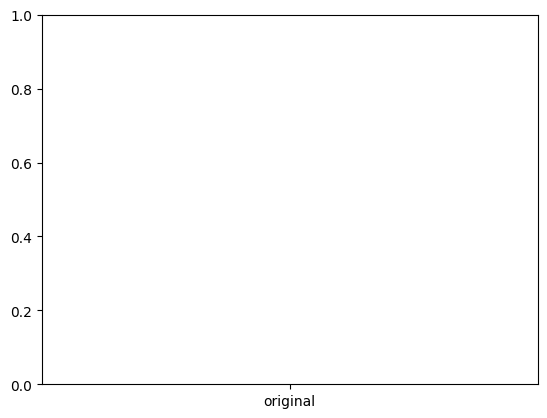

In [ ]:
model = rebuildModelENN(model_path, 8)

database = databaseGeneration(model, user_database)

enn_acc_1 = login(model, database, test_user, test_intruder, 0.94)

accuracy.append(enn_acc_1)
model = rebuildModelENN(model_path, 3)

database = databaseGeneration(model, user_database)

enn_acc_2 = login(model, database, test_user, test_intruder, 6)

accuracy.append(enn_acc_2)

model = rebuildModelENN(model_path, 4)

database = databaseGeneration(model, user_database)

enn_acc_3 = login(model, database, test_user, test_intruder, 9)

accuracy.append(enn_acc_3)

net = ['original', 'binary', 'exponent_n1', 'exponent_n2', 'exponent_n3']
fig, ax = plt.subplots()
plt.plot(net, accuracy, color='b')
plt.scatter(net, accuracy, color='r', marker='v')
plt.ylabel('Accuracy')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
for a, b in zip(net, accuracy):
  plt.text(a, b+0.001, '{:.2%}'.format(b), ha='center', va= 'bottom',fontsize=9)
plt.show()

In [ ]:
    dataset = pd.read_csv("/content/train90.csv")
    num_classes, X_train, X_test, Y_train, Y_test = createSet(dataset)
    Y_train_wide, Y_test_num, Y_test_wide = binaryConvertion(num_classes, Y_train, Y_test)
    model = modelling(X_train, Y_train_wide)
    evaluation(model, X_test, Y_test_num)